In [ ]:
import sys
sys.path.append("../")
import os
print(os.getcwd())
%pylab inline
import GPyOpt
import GPy
from AlphaOpt import components

In [2]:
from GPyOpt.objective_examples.experiments1d import *
from GPyOpt.objective_examples.experiments2d import *

# Output
func  = branin()
sd = 0 # Set the value for noise
y = branin(sd=sd)
input_dim = 2
num_cores = 4

# **IMPORTANT**: Objective should have num_cores specified.
objective = GPyOpt.core.task.SingleObjective(y.f, num_cores=num_cores)

# Input
v1_dom = func.bounds[0]
v2_dom = func.bounds[1]

space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': v1_dom},
                                   {'name': 'var_2', 'type': 'continuous', 'domain': v2_dom}])

In [3]:
# Bayesian Optimization Components
# GP models
kernel = GPy.kern.Matern52(input_dim=input_dim, ARD=True)
model = GPyOpt.models.GPModel(kernel=kernel, optimize_restarts=10, verbose=False)

# Cost model
# cost = GPyOpt.core.task.CostModel('evaluation_time')

In [4]:
from GPyOpt.core.evaluators.base import EvaluatorBase
class MultiAcquisitions(EvaluatorBase):
    def __init__(self, *args):
        self.acquisitions = args

    def compute_batch(self):
        X_batch = self.acquisitions[0].optimize()
        for i in range(1, len(self.acquisitions)):
            X_batch = np.vstack((X_batch,self.acquisitions[i].optimize()))
        return X_batch

In [5]:
# Decision models
acq_opt = GPyOpt.optimization.AcquisitionOptimizer(space)

# Use EI as the baseline
acq_fxs = [GPyOpt.acquisitions.AcquisitionEI(model, space, acq_opt), 
          components.EIXplore(model, space, acq_opt),
          GPyOpt.acquisitions.AcquisitionMPI(model, space, acq_opt),
          GPyOpt.acquisitions.AcquisitionLCB(model, space, acq_opt)]


eval_fx = MultiAcquisitions(*acq_fxs)

In [6]:
from GPyOpt.core.task.objective import SingleObjective
X_init = GPyOpt.util.stats.initial_design('random', space, 2)

bo = GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=objective,
                                                acquisition=None,
                                                evaluator=eval_fx,
                                                X_init=X_init)

In [7]:
bo.run_optimization(max_iter = 30, eps=1e-10, verbosity=True)

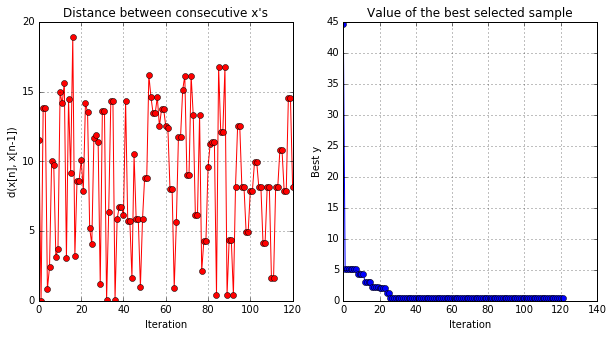

In [8]:
# Note: bo.plot_acquisition cannot be used here
bo.plot_convergence()